In [90]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SQLContext
import matplotlib.pyplot as plt
from pyspark.sql import functions as f
from pyspark.sql.types import *
import os
import sys

### The Dataset

Cardiovascular ailments (CVDs) stand as the primary culprit behind global mortality, claiming approximately 17.9 million lives annually, translating to 31% of all worldwide deaths. Within this statistic, four out of every five CVD-related deaths stem from heart attacks and strokes, with a troubling one-third of these fatalities occurring prematurely among individuals under the age of 70. Notably, heart failure emerges as a frequent outcome linked to CVDs. Enclosed within this dataset are 11 distinctive attributes that hold the potential to forecast the onset of heart disease.

Individuals grappling with cardiovascular disorders or those situated within the high-risk bracket (owing to factors such as hypertension, diabetes, hyperlipidemia, or preexisting conditions) necessitate early identification and effective management. In this pursuit, the deployment of a machine learning model stands poised as a valuable asset.

Thus, the heart disease predictor was created to be of use for early detection for possible intervention and monitoring.

The data used for the predictor was trained using the ["Heart Failure Prediction Dataset"](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) provided by user fedesoriano.

#### Feature Columns

1. Age: age of the patient [years] (Discrete)
2. Sex: sex of the patient [M: Male, F: Female] (Categorical)
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] (Categorical)
4. RestingBP: resting blood pressure [mm Hg] (Continuous)
5. Cholesterol: serum cholesterol [mm/dl] (Continuous)
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] (Categorical ; Boolean)
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] (Categorical)
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202] (Discrete)
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No] (Categorical ; Boolean)
10. Oldpeak: oldpeak = ST [Numeric value measured in depression] (Continuous)
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] (Categorical)

#### Target Column

1. HeartDisease: output class [1: heart disease, 0: Normal] (Categorical ; Boolean)

#### Source

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations

With a total of 1190 observations, there were 272 duplicated observations.

Final dataset: 918 observations

Every dataset used can be found under the Index of heart disease datasets from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/)

In [62]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [63]:
spark = SparkSession.builder.getOrCreate()

In [64]:
def read_csv(path):
    """
    Reads the path and takes the csv within to process.

    Parameters:
        path (string) : file path of the .csv file

    Returns:
        dataframe (spark dataframe) : the csv file as a spark dataframe with an inferred schema
    """
    dataframe = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(path)
    return dataframe

In [88]:
heart_data = read_csv("data/heart.csv")

##### Dataset Example

In [89]:
heart_data.toPandas().head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [67]:
# def get_mdn_or_md(dataframe, stat_type):
#     """
#     get_mdn_or_md : Retrieves the median or mode of the columns of the passed dataframe

#     :param dataframe: The dataframe to be assessed
#     :param stat_type: The type of desc. stat to return. ("mode" or "median")
#     :return stat_list: A list of the dataframe's corresponding column statistic values.
    
#     :raises ValueError: If a value other than "mode" or "median" is passed as an arg.
#     """
#     # Will hold the list of the dataframe's corresponding column's statistic values
#     stat_list = [stat_type]

#     # Will calculate the mode or median depending on what arg is passed
#     if stat_type == "mode":
#         summary_list = [dataframe.groupby(col).count()
#                         .orderBy("count", ascending=False).first()[0]
#                         for col in dataframe.columns]
#     elif stat_type == "median":
#         summary_list = [dataframe.groupBy()
#                         .agg(f.percentile_approx(col, 0.5)).first()[0]
#                         for col in dataframe.columns]
#     else:
#         raise ValueError("Invalid argument 'type' - Only accepted values : 'median', 'mode'")

#     # Will append all the calculated statistic values into the stat_list
#     for val in summary_list:
#         stat_list.append(val)

#     return stat_list

In [68]:
def getAgeGroup(dataframe):
    dataframe = dataframe.withColumn(
        "age_group",
        f.when((f.col("Age") >= 25) & (f.col("Age") <= 29), "late 20s")
        .when((f.col("Age") >= 30) & (f.col("Age") <= 34), "early 30s")
        .when((f.col("Age") >= 35) & (f.col("Age") <= 39), "late 30s")
        .when((f.col("Age") >= 40) & (f.col("Age") <= 44), "early 40s")
        .when((f.col("Age") >= 45) & (f.col("Age") <= 49), "late 40s")
        .when((f.col("Age") >= 50) & (f.col("Age") <= 54), "early 50s")
        .when((f.col("Age") >= 55) & (f.col("Age") <= 59), "late 50s")
        .when((f.col("Age") >= 60) & (f.col("Age") <= 64), "early 60s")
        .when((f.col("Age") >= 65) & (f.col("Age") <= 69), "late 60s")
        .when((f.col("Age") >= 70) & (f.col("Age") <= 74), "early 70s")
        .when((f.col("Age") >= 75) & (f.col("Age") <= 79), "late 70s"),
    )
    return dataframe

In [69]:
# # Returns the summary statistics of the heart_data dataset
# summary_stat = heart_data.summary("count", "stddev", "min", "max", "25%", "50%", "75%", "mean")

# # Obtain the median
# med_list = [get_mdn_or_md(heart_data, stat_type = 'median')]
# median_row = spark.createDataFrame(med_list, summary_stat.schema)
# summary_stat = summary_stat.union(median_row)

# # Obtain the mode
# md_list = [get_mdn_or_md(heart_data, stat_type = "mode")]
# mode_row = spark.createDataFrame(md_list, summary_stat.schema)
# summary_stat = summary_stat.union(mode_row)

##### Age

As age is considered to be a general measure of health, we can delve into this feature and obtain various insights. We can further ages by classifying them within the 5 year age group classification to easily identify 
which groups are more prone to heart failures.

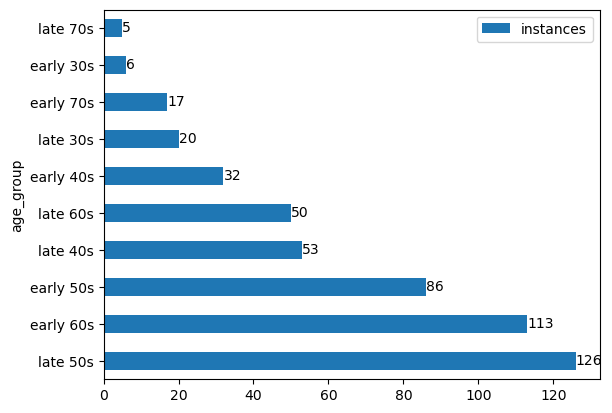

In [79]:
by_5_year_age = getAgeGroup(heart_data)
five_year_df = by_5_year_age.filter(f.col('HeartDisease') == 1).groupBy('age_group', 'HeartDisease').agg(f.count('HeartDisease').alias('instances')).select("age_group", "instances")
five_year_pd = five_year_df.toPandas().sort_values(by=["instances"],ascending = False).set_index('age_group').plot(kind='barh')
five_year_pd.bar_label(five_year_pd.containers[0])
plt.show()

Through this classification, we can see that those with the most instances of Heart Risk are in their 40s, 50s, and 60s.
We can also see that are few instances of heart risk in their early 30's and late 70's

##### Sex

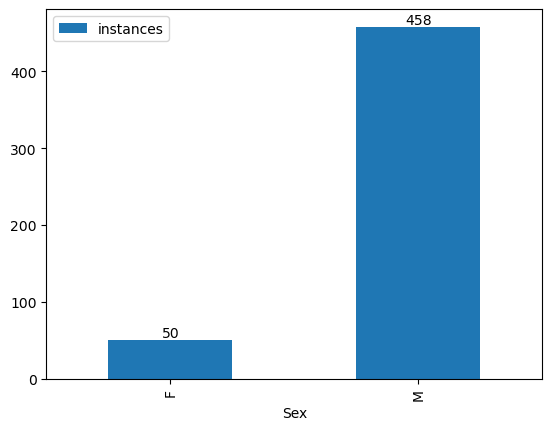

In [80]:
by_gender = heart_data.filter(f.col('HeartDisease') == 1).groupBy('Sex').agg(f.count(f.col('HeartDisease')).alias('instances')).select("Sex", "instances")
by_gender_pd = by_gender.toPandas().set_index('Sex').plot(kind = "bar")
by_gender_pd.bar_label(by_gender_pd.containers[0])
plt.show()

We can see males have more instances of being at risk than females.
We can look at this alongside the age range to understand how the distributions changes by age.

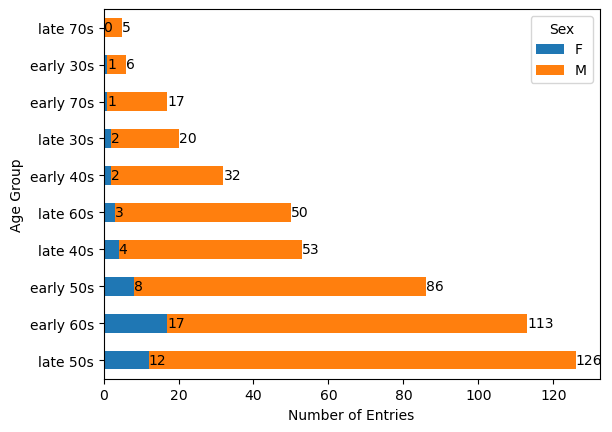

In [81]:
by_gender_age_pd = by_5_year_age.filter(f.col('HeartDisease') == 1).toPandas().groupby(['age_group', 'Sex']).size()
s_sort = by_gender_age_pd.groupby(level=[0]).sum().sort_values(ascending=False)
ax = by_gender_age_pd.reindex(index=s_sort.index, level=0).unstack().plot(kind = "barh", stacked=True)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_xlabel('Number of Entries')
ax.set_ylabel('Age Group')

plt.show()

Apart from having less instances of male entries from their 70ss and none in their late 20s, most of their entries from 
their late 30's up until their late 50s, with most female instances at their 60's.
From this, we can assume that heart risk is more prominent with those in their early 40's up until their late 60's.

##### Cholesterol

To better understand cholesterol levels, we can classify them according to the National Heart, Lung, and Blood Institute guidelines.
- A total cholesterol level of less than 200 mg/dL (5.17 mmol/L) is normal.

- A total cholesterol level of 200 to 239 mg/dL (5.17 to 6.18 mmol/L) is borderline high.

- A total cholesterol level of 240 mg/dL (6.21 mmol/L) or greater is high.

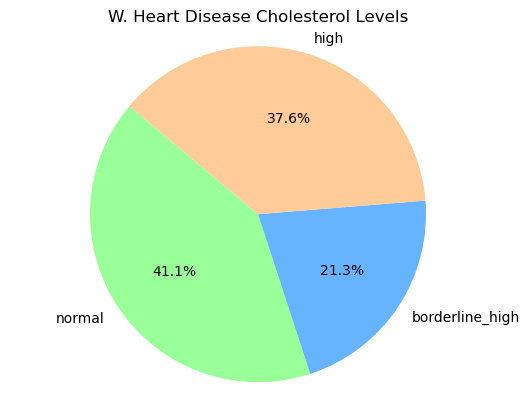

In [85]:
by_chol = heart_data.withColumn('chol_category', f.when(f.col('Cholesterol') < 200, 'normal').when((f.col('Cholesterol') >= 200) & (f.col('Cholesterol') <= 239), 'borderline_high').otherwise('high'))
chol_instances = by_chol.filter(f.col('HeartDisease') == 1).groupBy('chol_category').agg(f.count(f.col('HeartDisease')).alias('instances'))
df = chol_instances.toPandas()
colors = ['#99ff99', '#66b3ff', '#ffcc99']
plt.pie(df['instances'], labels=df['chol_category'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('W. Heart Disease Cholesterol Levels')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

As expected, we can see that most of those at risk have high cholesterol. However, we can also see that there is are those with normal cholesterol levels that are at risk for heart disease.

##### Blood Pressure

We can compare these findings with blood pressure (systolic). The following categories were recommended by the American Heart Association.
(Systolic mm Hg (upper number))
- NORMAL - LESS THAN 120
- ELEVATED	120 – 129
- HIGH BLOOD PRESSURE (HYPERTENSION) STAGE 1 - 130 – 139
- HIGH BLOOD PRESSURE (HYPERTENSION) STAGE 2 - 140 OR HIGHER
- HYPERTENSIVE CRISIS - HIGHER THAN 180

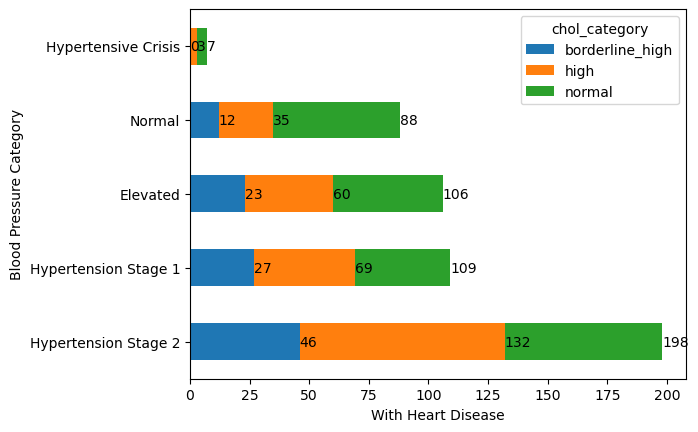

In [86]:
by_bp = by_chol.withColumn(
    "bp_category",
    f.when(f.col("RestingBP") < 120, "Normal")
    .when((f.col("RestingBP") >= 120) & (f.col("RestingBP") <= 129), "Elevated")
    .when((f.col("RestingBP") >= 130) & (f.col("RestingBP") <= 139), "Hypertension Stage 1")
    .when((f.col("RestingBP") >= 140) & (f.col("RestingBP") <= 180), "Hypertension Stage 2").when((f.col("RestingBP") > 180), "Hypertensive Crisis")
)
# chol_and_bp = by_bp.filter(f.col('HeartDisease') == 1).groupBy('bp_category', 'chol_category').agg(f.count(f.col('HeartDisease')).alias('instances')).orderBy('instances', ascending = False)
by_chol_bp_pd = by_bp.filter(f.col('HeartDisease') == 1).toPandas().groupby(['bp_category', 'chol_category']).size()
s_sort = by_chol_bp_pd.groupby(level=[0]).sum().sort_values(ascending=False)
ax = by_chol_bp_pd.reindex(index=s_sort.index, level=0).unstack().plot(kind = "barh", stacked=True)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.set_xlabel('With Heart Disease')
ax.set_ylabel('Blood Pressure Category')
plt.show()

We can see that regardless of cholesterol level, blood pressure takes most of the instances of heart disease. 
There are also come cases that even with normal bp and normal cholesterol levels, the risk of heart disease may still be present.